<a href="https://colab.research.google.com/github/Osterne/codes_DS_course/blob/main/05_mod_01_ap_sup_regressao_05_mlg_categoricos_logistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

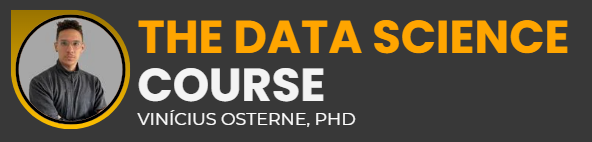

---

# Aprendizado Supervisionado - Modelos Baseados em Regressão

### Modelos Lineares Generalizados - Modelos para Dados Categóricos - Regressão Logística

---
<br><br><br><br><br>

---

## 🚦 Motivação e Contexto

- 🔢 Exemplos de variáveis binárias (0/1):  
  - ✅/❌ Aprovação de crédito  
  - 💉 Doente / Não doente  
  - 🛒 Compra / Não compra  
  - ⚽ Vitória / Derrota  

- ⚠️ Por que não usar Normal (OLS)?  
  - ❌ OLS pode prever probabilidades fora do intervalo [0,1].  
  - ❌ Erros não são homocedásticos.  
  - ❌ A relação entre preditores e resposta não é linear.  

> 💡 **Motivação**: A **Regressão Logística** modela a **probabilidade de sucesso** e garante valores entre 0 e 1.

<br><br><br>

---

## 🧩 Estrutura Geral dos Modelos Lineares Generalizados (MLG) para Logística

Um MLG é definido a partir de **três componentes principais**:

### 🎲 1. Componente Aleatório
- A variável resposta é binária:  
  $$
  Y_i \sim \text{Bernoulli}(\pi_i)
  $$
- Momentos:  
  $$
  \mathbb{E}[Y_i] = \pi_i, \qquad \text{Var}(Y_i) = \pi_i (1 - \pi_i)
  $$

---

### 📊 2. Componente Sistemático
- Representa a **combinação linear dos preditores**:  
  $$
  \eta_i = \mathbf{x}_i^\top \boldsymbol{\beta}
  $$

---

### 🔗 3. Função de Ligação
- Conecta a probabilidade $\pi_i$ ao previsor linear $\eta_i$:  
  $$
  g(\pi_i) = \eta_i
  $$

| Ligação        | Fórmula                          | Observações |
|----------------|----------------------------------|-------------|
| 🔑 **Logit (canônica)** | $g(\pi) = \log \frac{\pi}{1-\pi}$ | Mais usada; interpretação em termos de *odds ratio*. |
| ➡️ **Probit** | $g(\pi) = \Phi^{-1}(\pi)$ | Usa a CDF Normal; útil em bioestatística. |
| ➡️ **Complemento log-log** | $g(\pi) = \log(-\log(1-\pi))$ | Boa para eventos raros. |

---

✅ **Resumo para a Regressão Logística**  
- **Aleatório**: $Y_i \sim \text{Bernoulli}(\pi_i)$  
- **Sistemático**: $\eta_i = \mathbf{x}_i^\top \boldsymbol{\beta}$  
- **Ligação típica**: $\log \left(\frac{\pi}{1-\pi}\right) = \eta_i$  

<br><br><br>

---

## ⚠️ Limitações da Logística

- Não lida com **dependência temporal** ou correlação entre observações (usar modelos mistos ou GEE).  
- Para **desbalanceamento extremo** (ex.: 1% de sucessos), o ajuste pode ser instável.  
- Interpretação em termos de *odds ratio* pode não ser intuitiva para leigos.  

<br><br><br>

---

## 🔍 Comparações e Critérios de Escolha

- **Medidas de ajuste**:  
  - Deviance Residual, Pearson Residual.  
  - Pseudo-$R^2$ (McFadden, Nagelkerke).  
  - AUC (Área sob a curva ROC).  

- **Critérios de informação (AIC, BIC)**:  
  - Usados para comparar diferentes especificações de modelos.  

- **Regras práticas**:  
  - ✔️ **Logística**: para variáveis binárias comuns.  
  - ✔️ **Probit**: quando se assume normalidade latente.  
  - ✔️ **Complemento log-log**: para eventos raros.  

<br><br><br>

---

## 📌 Comentário em relação a outros GLMs
- Diferente de Gama/Normal Inversa (para dados contínuos positivos), a **Logística** é voltada a **respostas binárias**.  
- Todos compartilham a mesma estrutura (Aleatório + Sistemático + Ligação), mas variam pela escolha da distribuição e do link.  

<br><br><br>

---

## 🔍 Aplicação (em Python)

- Pacotes necessários  
- Carregamento dos dados  
- Estatística Descritiva  
- Ajuste do Modelo (GLM Logit)  
- Interpretação dos resultados  
- Diagnóstico do ajuste

### Aplicação

In [36]:
# ----------------------------------------------------
# 1. Pacotes necessários
# ----------------------------------------------------
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

$$x^2$$

In [58]:
# ----------------------------------------------------
# 2. Carregamento dos dados (simulação controlada)
# ----------------------------------------------------
np.random.seed(123)
n = 500

# Variáveis preditoras
valor_transacao = np.random.normal(200, 50, n)         # transações mais altas = mais chance de fraude
hora = np.random.randint(0, 24, n)                     # transações em horários "estranhos" = mais fraude
qtd_transacoes_usuario = np.random.poisson(2, n)       # usuários com muitas transações = mais fraude

# Relação real (logit)
log_odds = (
    -8 +                          # intercepto
    0.02 * valor_transacao +      # efeito positivo
    0.08 * hora +                 # efeito positivo
    0.5 * qtd_transacoes_usuario  # efeito positivo
)

# Convertendo log-odds para probabilidade
prob = 1 / (1 + np.exp(-log_odds))

# Gerando variável resposta
fraude = np.random.binomial(1, prob)

df = pd.DataFrame({
    "valor_transacao": valor_transacao,
    "hora": hora,
    "qtd_transacoes_usuario": qtd_transacoes_usuario,
    "fraude": fraude
})
df.head(4)

,valor_transacao,hora,qtd_transacoes_usuario,fraude
0,145.718470,5,2,0
1,249.867272,18,3,0
2,214.148925,22,2,1
3,124.685264,7,2,0


In [38]:
# ----------------------------------------------------
# 3. Estatística Descritiva
# ----------------------------------------------------
print(df.head())
print(df["fraude"].value_counts(normalize=True))

   valor_transacao  hora  qtd_transacoes_usuario  fraude
0       145.718470     5                       2       0
1       249.867272    18                       3       0
2       214.148925    22                       2       1
3       124.685264     7                       2       0
4       171.069987    12                       2       0
fraude
0    0.822
1    0.178
Name: proportion, dtype: float64


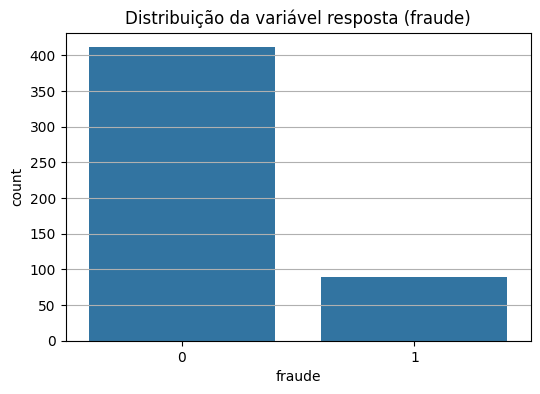

In [39]:
sns.countplot(x="fraude", data=df)
plt.title("Distribuição da variável resposta (fraude)")
plt.show()

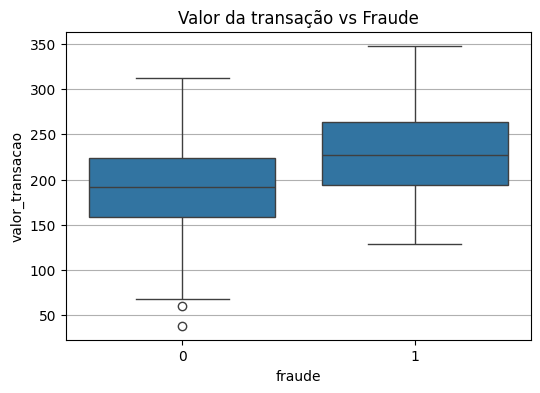

In [40]:
sns.boxplot(x="fraude", y="valor_transacao", data=df)
plt.title("Valor da transação vs Fraude")
plt.show()

      NaoFraude  Fraude  Total  PctFraude
hora                                     
0            14       3     17  17.647059
1            21       1     22   4.545455
2            26       1     27   3.703704
3            16       0     16   0.000000
4            26       2     28   7.142857
5            21       2     23   8.695652
6            19       2     21   9.523810
7            13       4     17  23.529412
8            18       3     21  14.285714
9            15       1     16   6.250000


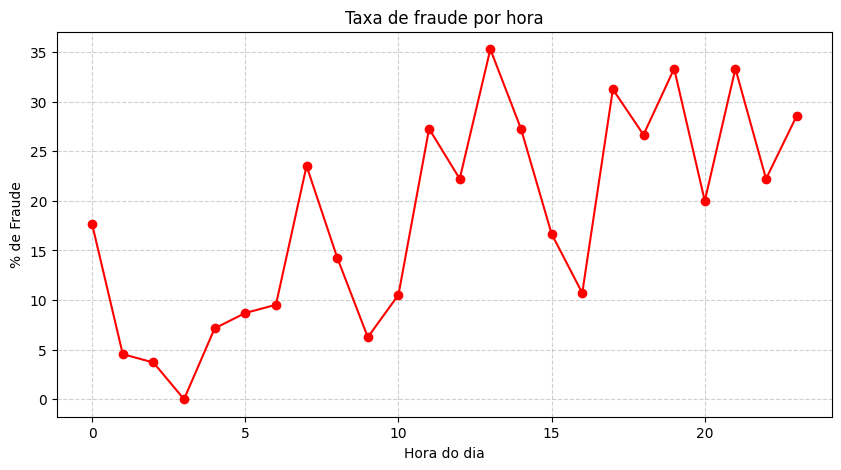

In [56]:
import matplotlib.pyplot as plt

# --------------------------------------------
# Fraude por hora
# --------------------------------------------
tab_hora = df.groupby("hora")["fraude"].value_counts().unstack(fill_value=0)
tab_hora.columns = ["NaoFraude", "Fraude"]
tab_hora["Total"] = tab_hora["NaoFraude"] + tab_hora["Fraude"]
tab_hora["PctFraude"] = 100 * tab_hora["Fraude"] / tab_hora["Total"]

print(tab_hora.head(10))  # ver primeiras 10 horas

plt.figure(figsize=(10,5))
plt.plot(tab_hora.index, tab_hora["PctFraude"], marker="o", color="red")
plt.xlabel("Hora do dia")
plt.ylabel("% de Fraude")
plt.title("Taxa de fraude por hora")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [41]:
# ----------------------------------------------------
# 4. Ajuste do Modelo (GLM Logit)
# ----------------------------------------------------
X = df[["valor_transacao", "hora", "qtd_transacoes_usuario"]]
X = sm.add_constant(X)
y = df["fraude"]

modelo = sm.Logit(y, X).fit()
print(modelo.summary())

Optimization terminated successfully.
         Current function value: 0.366729
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 fraude   No. Observations:                  500
Model:                          Logit   Df Residuals:                      496
Method:                           MLE   Df Model:                            3
Date:                Sun, 14 Sep 2025   Pseudo R-squ.:                  0.2170
Time:                        14:29:36   Log-Likelihood:                -183.36
converged:                       True   LL-Null:                       -234.17
Covariance Type:            nonrobust   LLR p-value:                 6.975e-22
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -8.1232      0.869     -9.352      0.000      -9.826      

In [59]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import pandas as pd

# Padronizar variáveis explicativas
X_raw = df[["valor_transacao", "hora", "qtd_transacoes_usuario"]]
scaler = StandardScaler()
X_std = scaler.fit_transform(X_raw)
X_std = sm.add_constant(X_std)

# Ajustar modelo com variáveis padronizadas
modelo_std = sm.Logit(y, X_std).fit()

# Coeficientes padronizados (tirando o intercepto)
coef_std = modelo_std.params.drop("const").abs()

# Importância percentual
importancia_pct = 100 * coef_std / coef_std.sum()

# Montar ranking com os nomes originais
ranking = pd.DataFrame({
    "Variável": X_raw.columns,
    "Importância (%)": importancia_pct.values
}).sort_values(by="Importância (%)", ascending=False)

print(ranking)

Optimization terminated successfully.
         Current function value: 0.366729
         Iterations 7
                 Variável  Importância (%)
0         valor_transacao        40.664657
2  qtd_transacoes_usuario        31.175557
1                    hora        28.159786


In [53]:

# ----------------------------------------------------
# 5. Interpretação dos resultados
# ----------------------------------------------------
df["prob_fraude"] = modelo.predict(X)
df["pred_fraude"] = (df["prob_fraude"] >= 0.5).astype(int)

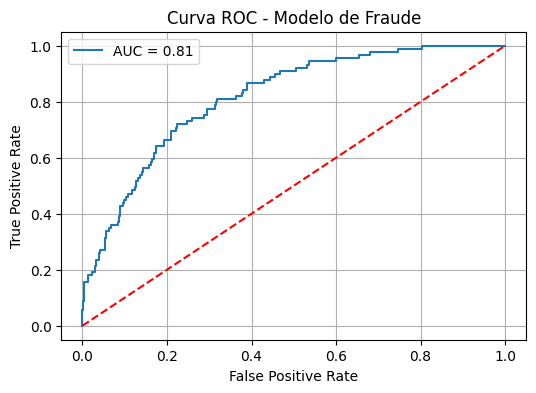

In [48]:
# ----------------------------------------------------
# 6. Diagnóstico do ajuste
# ----------------------------------------------------
fpr, tpr, _ = roc_curve(y, df["prob_fraude"])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="red")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Modelo de Fraude")
plt.legend()
plt.show()

In [49]:
from sklearn.metrics import roc_curve
import numpy as np

# Probabilidades previstas do modelo
y_true = y
y_score = df["prob_fraude"]

# Curva ROC dá TPR (sensibilidade) e FPR (1 - especificidade)
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# KS é a diferença máxima entre TPR e FPR
ks_stat = max(tpr - fpr)

print(f"KS = {ks_stat:.3f} ({ks_stat*100:.1f}%)")


KS = 0.495 (49.5%)
